In [1]:
import time
import datetime
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sbs

import pickle

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, log_loss

from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn.calibration import calibration_curve

from sklearn.feature_selection import RFECV

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_SEED = 42
VERSION = 4
GOOD_CNTR_CLR = '#5FFF92'
BAD_CNTR_CLR = '#FF665F'

pd.set_option('display.max_columns', 80)
pd.options.mode.chained_assignment = None

In [3]:
def save_model(clf, clf_name, version=VERSION):
    """Сохранение модели"""
    with open('model/{}_{}_mdl.pkl'.format(version, clf_name.lower()), 'wb') as file:
        pickle.dump(clf, file)
        
def save_scaler(scl, version=VERSION):
    """Сохранение нормализатора"""
    with open('model/{}_sk.pkl'.format(version), 'wb') as file:
        pickle.dump(scl, file)
        
def load_model(clf_name, version=VERSION):
    """Загрузка модели"""
    with open('model/{}_{}_mdl.pkl'.format(version, clf_name.lower()), 'rb') as file:
        return pickle.load(file)
    
def load_scaler(version=VERSION):
    """Загрузка нормализатора"""
    with open('model/{}_sk.pkl'.format(version), 'rb') as file:
        return pickle.load(file)

### Считывание данных и их предобработка

In [4]:
def grouped_initial_vars():
    """Список сгруппированных по типу переменных"""
    
    # Список количественных переменных с нефиксированной областью значений
    num_var = [
        'sup_cntr_num', 'sup_running_cntr_num', 'sup_cntr_avg_price', 'org_cntr_num', 
        'org_cntr_avg_price', 'org_running_cntr_num','price', 'pmp',
        'cntr_num_together', 'cntr_length', 'one_day_price'
    ]

    # Список количественных переменных с областью значений от 0 до 1 без учета 'sup_okpd_exp'
    num_var01 = [
            'sup_good_cntr_share', 'sup_fed_cntr_share', 'sup_sub_cntr_share', 
            'sup_mun_cntr_share', 'sup_cntr_avg_penalty_share', 'sup_1s_sev', 'sup_1s_org_sev',  
            'sup_no_pnl_share', 'sup_sim_price_share', 'org_good_cntr_share', 'org_fed_cntr_share', 
            'org_sub_cntr_share', 'org_mun_cntr_share', 'org_1s_sev', 'org_1s_sup_sev', 'org_sim_price_share', 
            'okpd_good_cntr_share'
        ]

    # Список категориальных переменных
    cat_var = ['org_type', 'okpd2', 'purch_type', 'quarter']

    # Список бинарных переменных
    cat_bin_var = ['price_higher_pmp', 'price_too_low']
    
    return num_var, num_var01, cat_var, cat_bin_var

In [5]:
def delete_useless_vars(num_var, num_var01, cat_var, cat_bin_var):
    """
    Удаление бесмысленных переменных на основе 
    предварительного анализа данных
    """
    
    for nv in ('cntr_num_together', 'price', 'pmp'):
        num_var.remove(nv)

    for nv01 in ('sup_cntr_avg_penalty_share', 'sup_1s_sev', 'sup_1s_org_sev', 
        'sup_no_pnl_share', 'org_fed_cntr_share', 'org_sub_cntr_share', 
        'org_mun_cntr_share', 'org_1s_sev', 'org_1s_sup_sev'):
        num_var01.remove(nv01)

    for cv in (): cat_var.remove(cv)

    cat_bin_var.clear()

In [6]:
def process_numerical(df, num_var, num_var01, train=True):
    """Обработка количественных переменных"""
    if train:
        process_numerical.cache = {}
        scaler = StandardScaler()
    else:
        scaler = load_scaler()
    
    for nv in df[num_var]:
        if train:
            ulimit = np.percentile(df[nv].values, 99)
            dlimit = np.percentile(df[nv].values, 1)
            process_numerical.cache[nv] = (dlimit, ulimit)
        else:
            ulimit = process_numerical.cache[nv][1]
            dlimit = process_numerical.cache[nv][0]
            
        df.loc[df[nv] > ulimit, nv] = ulimit
        df.loc[df[nv] < dlimit, nv] = dlimit
    
    for nv in df[num_var]:
        df.loc[df[nv] < 1, nv] = 1
        df.loc[:,nv] = np.log(df[nv])
    
    if train:
        df.loc[:,num_var] = scaler.fit_transform(df[num_var])
        save_scaler(scaler)
    else:
        df.loc[:,num_var] = scaler.transform(df[num_var])
        
    return df

In [7]:
def process_nominal(df, cat_var, cat_bin_var, train=True):
    """Обработка номинальных переменных"""
    
    if train:
        group_converters = {}
        woe_converters = {}

        for cv in cat_var:
            cnt = df[cv].value_counts()
            for val, count in zip(cnt.index, cnt.values):
                if count / df.shape[0] <= 0.005:
                    df.loc[df[cv] == val, cv] = 'NEW'

            conv = {}
            for val in set(df[cv]):
                if val != 'NEW': conv[val] = val

            group_converters[cv] = conv

        for cv in cat_var:
            cnt = df[cv].value_counts()
            conv = {}
            for val, count in zip(cnt.index, cnt.values):
                good_with_val = df.loc[(df.cntr_result == 1) & (df[cv] == val)].shape[0]
                bad_with_val = df.loc[(df.cntr_result == 0) & (df[cv] == val)].shape[0]

                p = good_with_val / df.loc[df.cntr_result == 1].shape[0]
                q = bad_with_val / df.loc[df.cntr_result == 0].shape[0]
                woe = round(np.log(p / q), 3)

                conv[val] = woe
                df.loc[df[cv]==val, cv] = round(np.log(p / q), 3)

            woe_converters[cv] = conv
       
        process_nominal.gp_convs = group_converters
        process_nominal.woe_convs = woe_converters
    else:
        for cv in cat_var:
            df.loc[:,cv] = df[cv].map(process_nominal.gp_convs[cv])
            df.loc[:,cv] = df[cv].fillna('NEW')
            df.loc[:,cv] = df[cv].map(process_nominal.woe_convs[cv])

    return df

In [8]:
def data_preprocessing(df, train=True):
    """Предобработка данных"""
    
    num_var, num_var01, cat_var, cat_bin_var = grouped_initial_vars()
    delete_useless_vars(num_var, num_var01, cat_var, cat_bin_var)
    
    df = process_numerical(df, num_var, num_var01, train=train)
    df = process_nominal(df, cat_var, cat_bin_var, train=train)
    
    used_vars = ['cntrID'] + num_var + num_var01 + cat_var + cat_bin_var + ['cntr_result']
    
    return df[used_vars]

In [9]:
# Обучающая выборка
df = pd.read_csv('../data/4/train_test.csv', encoding='utf-8')

print(df.shape)
df.head()

(53979, 47)


,valID,cntrID,supID,orgID,okpdID,sup_cntr_num,sup_running_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty_share,sup_no_pnl_share,sup_1s_sev,sup_1s_org_sev,sup_okpd_cntr_num,sup_sim_price_share,org_cntr_num,org_running_cntr_num,org_cntr_avg_price,org_1s_sev,org_1s_sup_sev,org_sim_price_share,cntr_num_together,org_type,okpd_cntr_num,okpd_good_cntr_num,price,pmp,cntr_lvl,sign_date,exec_date,purch_type,price_higher_pmp,price_too_low,cntr_result,okpd2,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_mun_cntr_share,sup_okpd_exp,org_good_cntr_share,org_fed_cntr_share,org_sub_cntr_share,org_mun_cntr_share,okpd_good_cntr_share,quarter,cntr_length,one_day_price
0,57692890,32352291,10135334,467566,153861,6,3,165150,0.0,1.0,0,0.0,1,0.333,2012,212,2003501,0,0.0,0.100,1,16,5646.0,5717,233280,288000,1,20160512,20161231,3,0,0,0.0,27,1.000000,0.666667,0.333333,0.000000,0.166667,0.990060,1.0,0.0,0.0,1.011099,2,233,1001
1,211683097,34748597,10490076,480718,151943,1,0,255590,0.0,1.0,0,0.0,1,1.000,467,218,1125626,0,0.0,0.113,1,16,24319.0,24601,255590,0,1,20160824,20161231,3,0,0,0.0,22,1.000000,1.000000,0.000000,0.000000,1.000000,0.985011,1.0,0.0,0.0,1.010274,3,129,1981
2,58994828,32503663,10147390,520420,151705,217,162,60633,0.0,1.0,0,0.0,8,0.088,538,89,133321,0,0.0,0.102,11,18,16026.0,16425,85433,94410,1,20160907,20161130,3,0,0,0.0,21,0.986175,0.211982,0.788018,0.000000,0.603687,0.968401,1.0,0.0,0.0,1.036036,3,84,1017
3,208185735,40043960,10197821,207848,150662,3,0,187902,0.0,1.0,0,0.0,2,0.333,1108,157,12627129,0,0.0,0.103,1,30,4160.0,4191,408409,0,1,20170321,20170531,3,0,0,0.0,19,1.000000,0.666667,0.000000,0.333333,0.666667,0.993682,1.0,0.0,0.0,1.079040,1,71,5752
4,59431305,33698468,10326174,90470,157012,3,0,180288,0.0,1.0,0,0.0,2,0.333,350,240,397033,0,0.0,0.111,2,30,2770.0,3117,52859,52859,1,20161025,20161231,3,0,0,1.0,61,0.666667,1.000000,0.000000,0.000000,0.666667,0.740000,1.0,0.0,0.0,1.070969,4,67,788


In [10]:
threshold = int(df.shape[0] * 0.2)

# Тренировочная выборка
df_train = df.iloc[threshold:,:]
# Валидационная выборка
df_valid = df.iloc[:threshold,:]

In [11]:
df_train = data_preprocessing(df_train, train=True)

print(df_train.shape)
df_train.head()

(43184, 22)


,cntrID,sup_cntr_num,sup_running_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,org_running_cntr_num,cntr_length,one_day_price,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_mun_cntr_share,sup_sim_price_share,org_good_cntr_share,org_sim_price_share,okpd_good_cntr_share,org_type,okpd2,purch_type,quarter,cntr_result
10795,32462781,-0.571102,-0.693879,1.135348,-1.202811,-1.217703,-0.772390,-0.485287,-0.166489,0.333333,0.333333,0.666667,0.0,0.333,0.982143,0.152,1.083690,0.242,1.778,-0.088,0.488,1.0
10796,27732584,0.357884,0.896791,1.500541,-0.233474,-0.236887,0.301347,-0.034588,0.255359,1.000000,0.866667,0.133333,0.0,0.133,0.684211,0.126,1.108748,-0.36,0.277,-0.088,-0.277,0.0
10797,33348413,1.052832,-0.693879,1.207191,-0.291210,0.487956,0.155088,-0.166748,0.807208,1.000000,1.000000,0.000000,0.0,0.080,0.978125,0.094,1.029635,0.322,0.647,-0.088,-0.029,0.0
10798,30774295,-1.205234,-0.693879,-0.387771,-0.119430,0.975138,-0.789023,1.014680,-0.785989,0.000000,1.000000,0.000000,0.0,1.000,0.956410,0.077,1.203434,0.242,0.168,0.265,0.488,1.0
10799,38343375,-1.205234,-0.693879,0.034104,1.394225,-0.226021,0.885676,-0.485287,0.428018,0.000000,1.000000,0.000000,0.0,1.000,0.866756,0.103,1.072857,0.02,1.43,-0.088,-0.029,1.0


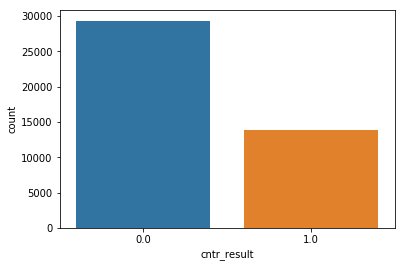

In [12]:
sbs.countplot(x='cntr_result', data=df_train)

In [13]:
# Балансировка выборки
bad_cntr = df_train.loc[df_train.cntr_result == 1]
good_cntr = df_train.loc[df_train.cntr_result == 0].sample(bad_cntr.shape[0], random_state=RANDOM_SEED)
data = bad_cntr.append(good_cntr)

# Перемешивание
data = data.sample(frac=1, random_state=RANDOM_SEED)

print(data.shape)
data.head()

(27674, 22)


,cntrID,sup_cntr_num,sup_running_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,org_running_cntr_num,cntr_length,one_day_price,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_mun_cntr_share,sup_sim_price_share,org_good_cntr_share,org_sim_price_share,okpd_good_cntr_share,org_type,okpd2,purch_type,quarter,cntr_result
22994,34618093,1.577089,1.605155,0.251177,1.070315,0.839343,1.740518,-0.990593,1.938324,1.000000,0.209677,0.790323,0.000000,0.016,0.985668,0.036,1.203434,0.02,0.168,-0.088,-0.029,0.0
30985,36010331,-0.082032,0.034898,0.085075,0.179080,-0.374170,0.524611,-1.484902,1.056065,0.857143,0.428571,0.142857,0.428571,0.143,0.867273,0.085,1.019060,0.322,-1.051,-0.088,-0.029,0.0
41708,39894372,-1.205234,-0.693879,-1.870438,-0.468178,1.224373,0.172027,-0.553221,-1.037474,0.000000,1.000000,0.000000,0.000000,1.000,0.628352,0.042,1.083690,0.322,1.778,0.265,0.488,1.0
25543,32547749,-1.205234,-0.693879,-0.020568,0.988514,0.577840,0.509385,0.615337,-0.260971,0.000000,1.000000,0.000000,0.000000,1.000,0.987115,0.074,1.026700,0.322,-0.5,-0.088,0.488,1.0
14057,32884091,-0.276248,-0.693879,-1.499207,0.103238,-1.056688,-0.077153,-1.108030,0.193478,0.800000,0.400000,0.000000,0.600000,0.200,0.970238,0.069,1.203434,0.242,0.168,-0.088,-0.029,1.0


### Обучение моделей

In [14]:
def print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba):
    """Презентация основной информации об обученной модели"""
    
    print_str = (
        '{0}\n{1}\n{2}\nAccuracy на обучающей выборке: {3:.3f}\n'
        'Accuracy на тестовой выборке: {4:.3f}\n'
        'Log loss на тестовой выборке: {5:.3f}\n{1}\n'
    ).format(
        clf_name.upper(),
        "=" * 55 + '\n',
        classification_report(y_test_real, y_test_pred, target_names=('Хороший', 'Плохой')),
        accuracy_score(y_train_real, y_train_pred),
        accuracy_score(y_test_real, y_test_pred),
        log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba)
    )
    print(print_str)

def real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba):
    """
    Построение соответствия между реальными и предсказываемыми моделью 
    значениями целевой переменной
    """
    
    return pd.DataFrame({'result': y_test_real}).join(
        pd.DataFrame({'proba_pred':y_test_pred_proba[:,1]}).join(
            pd.DataFrame({'pred': y_test_pred})
        )
    )

def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинные значения')
    plt.xlabel('Предсказываемые значения')
    plt.show()
    
def plot_dependence(res, title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0, counter1 = Counter(), Counter()

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Хорошие контракты', 'Плохие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_test_real, y_test_pred_proba):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

def learn_one_model(clf, clf_name, X, y, kfold=10, silent=False):
    """Функция для обучения одной модели"""
    
    start_time = time.time()
    
    if silent:
        print('Обучение %s' % clf_name)
    
    # Кросс-валидация 
    kfolds_generator = StratifiedKFold(n_splits=kfold, random_state=RANDOM_SEED)
    for idx, (train_index, test_index) in enumerate(kfolds_generator.split(X, y)):
        if not silent:
            print('Обучение {} разбиения'.format(idx + 1))
        
        X_train = X[train_index]
        X_test = X[test_index]
    
        y_train = y[train_index]
        y_test = y[test_index]
    
        clf.clf.fit(X_train, y_train)
    
        clf.y_train_real = np.concatenate((clf.y_train_real, y_train))
        clf.y_test_real = np.concatenate((clf.y_test_real, y_test))

        clf.y_train_pred = np.concatenate((clf.y_train_pred, clf.clf.predict(X_train)))
        clf.y_test_pred = np.concatenate((clf.y_test_pred, clf.clf.predict(X_test)))
        
        clf.y_train_pred_proba = np.concatenate((clf.y_train_pred_proba, clf.clf.predict_proba(X_train))) 
        clf.y_test_pred_proba = np.concatenate((clf.y_test_pred_proba, clf.clf.predict_proba(X_test))) 
    
    # Соответствие между реальными и предсказываемыми моделью значениями целевой переменной
    clf.res = real_and_predicted_correlation(clf.y_test_real, clf.y_test_pred, clf.y_test_pred_proba)
    
    # Время обучения модели
    clf.train_time = int(time.time() - start_time)
    
    # Сохранение модели
    save_model(clf.clf, clf_name)
    
    if not silent:
        print("Обучение заняло %s секунд\n" % (time.time() - start_time))
        # Общая информация о модели
        print_classifier_info(
            clf_name, clf.y_train_real, clf.y_train_pred, 
            clf.y_test_real, clf.y_test_pred, clf.y_test_pred_proba
        )
        
        # Матрица ошибок
        plot_confusion_matrix(
            confusion_matrix(clf.y_test_real, clf.y_test_pred), 
            classes=clf.clf.classes_, 
            title='Матрица ошибок'
        )
        
        # Распределение конрактов
        plot_dependence(clf.res)
        
        # ROC-кривая
        plot_roc_curve(clf.y_test_real, clf.y_test_pred_proba[:,1])

def assess_probability_power(clfs, figsize=(20, 10)):
    """Визуализации вероятностной предсказательной силы классификатора"""
    
    fig = plt.figure(figsize=figsize)
    clf_num = len(clfs)
    res = {}
    
    if clf_num > 4:
        raise Warning('Данную функцию рекоммендуется использовать для 1-4 моделей')
    
    for idx, clf in enumerate(clfs):
        ax1 = fig.add_subplot(2, clf_num, idx + 1)    
        ax1.plot([0, 1], [0, 1], "k:", label="Идеальный классификатор")
        ax2 = fig.add_subplot(2, clf_num, idx + 1 + clf_num)

        fraction_of_positives, mean_predicted_value = calibration_curve(
            clf.y_test_real, clf.y_test_pred_proba[:,1], n_bins=10)

        ax1.plot(
            mean_predicted_value, fraction_of_positives, "s-", 
            label='%s (log loss: %1.3f)' % (clf.short_name, log_loss(clf.y_test_real, clf.y_test_pred_proba))
        )
        ax2.hist(clf.y_test_pred_proba[:,1], range=(0, 1), bins=10, histtype="step", lw=2)

        ax1.set_ylabel('Доля наблюдений плохого класса')
        ax1.set_xlabel('Средняя предсказываемая вероятность')
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc='lower right')
        ax1.set_title(clf.short_name)

        ax2.set_ylabel('Количество наблюдений')
        ax2.set_xlabel('Средняя предсказываемая вероятность')

### Анализ моделей

In [15]:
def plot_training_time(classifiers):      
    # Время обучения моделей
    y_pos = range(len(classifiers))
    train_time = [clf.train_time for clf in classifiers]

    plt.bar(y_pos, train_time, alpha=0.5)
    plt.xticks(y_pos, [clf.short_name for clf in classifiers])
    plt.title('Время обучения алгоритмов')
    plt.ylim(0, int(max(train_time)*1.25))

    for idx, tt in enumerate(train_time):
        plt.text(idx, tt + 1, str(tt), ha='center')

    plt.show()
    
def feature_importance(classifiers):
    """Анализ важности признаков для алгоритма"""
    
    result = {}
    
    # Признаки в порядке убывания важности для каждой модели
    for clf in classifiers:
        feature_importance = None
        
        # coef_ для лог.регрессии
        if clf.model_code == 'LR':
            feature_importance = sorted(
                list(zip(data.columns[1:-1], classifiers[0].clf.coef_[0])),
                key=lambda a: np.abs(a[1]), 
                reverse=True
            )
        # feature_importances_ для остальных моделей
        else:
            feature_importance = sorted(
                list(zip(data.columns[1:-1], classifiers[1].clf.feature_importances_)),
                key=lambda a: a[1], 
                reverse=True
            )

        result[clf.short_name] = ['{}: {:.2f}'.format(elem[0], elem[1]) for elem in feature_importance]
    
    return pd.DataFrame(result)

def plot_confusion_matrixes(classifiers, normalize=False, title='Матрица ошибок', figsize=(20, 10), cmap=plt.cm.Blues):
    """Построение матрицы ошибок"""
    
    fig = plt.figure(figsize=figsize)
    num_of_clf = len(classifiers)
    tick_marks = np.arange(2)
    
    for idx, clf in enumerate(classifiers):
        ax = fig.add_subplot(1, num_of_clf, idx + 1)
            
        cm = confusion_matrix(clf.y_test_real, clf.y_test_pred)
        classes = clf.clf.classes_
   
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        ax.imshow(cm, interpolation='nearest', cmap=cmap)
        
        ax.set_title(title + ' ' + clf.short_name)
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('Истинные значения')
        ax.set_xlabel('Предсказываемые значения')

def custom_classification_report(classifiers):
    """
    Кастомный вариант classification_report для нескольких моделей
    """
    
    scores = []
    for clf in classifiers:
        scores.append([
            precision_score(clf.y_test_real, clf.y_test_pred, pos_label=0),
            precision_score(clf.y_test_real, clf.y_test_pred, pos_label=1),
            recall_score(clf.y_test_real, clf.y_test_pred, pos_label=0),
            recall_score(clf.y_test_real, clf.y_test_pred, pos_label=1),
            accuracy_score(clf.y_test_real, clf.y_test_pred)]
        )
        
    return pd.DataFrame(
        np.transpose(np.array(scores)),
        index=['precision_0', 'precision_1', 'recall_0', 'recall_1', 'accuracy'],
        columns=[clf.short_name for clf in classifiers]).round(3)

def plot_dependences(classifiers, figsize=(20, 10), title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    fig = plt.figure(figsize=figsize)
    num_of_clf = len(classifiers)
    
    for idx, clf in enumerate(classifiers):
        ax = fig.add_subplot(230 + idx + 1)
        
    
        counter0, counter1 = Counter(), Counter()

        for index, row in clf.res.iterrows():
            proba = round(row['proba_pred'], 2)

            if row['result']:
                counter1[proba] += 1
            else:
                counter0[proba] += 1
    
        corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
        corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
        ax.plot(corr_df0['index'], corr_df0[0], label='Хорошие контракты')
        ax.plot(corr_df1['index'], corr_df1[0], label='Плохие контракты')

        ax.legend()
        ax.set_xlabel('Предсказываемая вероятность плохого исхода')
        ax.set_ylabel('Реальное количество контрактов')
        ax.set_title(clf.short_name)
        
def visualize_clfs_quality(classifiers):
    """Построение основных графиков для всех моделей"""
    
    # Матрица ошибок
    plot_confusion_matrixes(classifiers)

    # Вероятностное предсказательное качество модели
    plot_dependences(classifiers)

    # Альтернативный способ визуализации вероятностного предсказательного качества классификаторов
    assess_probability_power(classifiers)

In [16]:
X = data.drop(['cntr_result', 'cntrID'], axis=1).values
y = data.cntr_result.values

### Модели с параметрами по умолчанию

In [17]:
class Classifier():
    """Класс для удобства обучения моделей"""
    
    def __init__(self, clf, name, short_name, model_code):
        self.clf = clf
        self.name = name
        self.short_name = short_name
        self.model_code = model_code
    
    y_train_real = np.array([])
    y_test_real = np.array([])
    
    y_train_pred = np.array([])
    y_test_pred = np.array([])
    
    y_train_pred_proba = np.zeros((0, 2))
    y_test_pred_proba = np.zeros((0, 2))

In [18]:
# Классификаторы
classifiers = [
    Classifier(LogisticRegression(random_state=RANDOM_SEED), 'LogisticRegression', 'LogReg', 'LR'),
    Classifier(RandomForestClassifier(random_state=RANDOM_SEED), 'RandomForestClassifier', 'RandForest', 'RF'),
    Classifier(XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1), 'XGBoostClassifier', 'XGBoost', 'XGB'),
]

In [19]:
%%time
 # Обучение классификаторов на кросс-валидации 
scores = []
metrics = ['roc_auc', 'accuracy', 'neg_log_loss']
for clf in classifiers:
    scores.append(
        cross_validate(
            clf.clf, X, y, scoring=metrics, 
            cv=10, return_train_score=True
        )
    )

Wall time: 19.1 s


In [20]:
# Вывод результатов 
res = {}
metric_keys = ['train_{}'.format(metric) for metric in metrics]
metric_keys.extend(['test_{}'.format(metric) for metric in metrics])

for clf, score in zip(classifiers, scores):
    res[clf.short_name] = [np.mean(score[metric]) for metric in metric_keys]
    
res = pd.DataFrame(res, index=metric_keys)
res = res.round(decimals=3)
res = res[['LogReg', 'RandForest', 'XGBoost']]
res

,LogReg,RandForest,XGBoost
train_roc_auc,0.967,1.000,0.981
train_accuracy,0.899,0.996,0.926
train_neg_log_loss,-0.249,-0.053,-0.167
test_roc_auc,0.967,0.971,0.979
test_accuracy,0.899,0.917,0.922
test_neg_log_loss,-0.250,-0.415,-0.175


In [21]:
%%time
# Обучение моделей с помощью самописной функции
for clf in classifiers:
    learn_one_model(clf, clf.short_name, X, y, silent=True)

Обучение LogReg
Обучение RandForest
Обучение XGBoost
Wall time: 21.1 s


In [22]:
# Основные метрики
custom_classification_report(classifiers)

,LogReg,RandForest,XGBoost
precision_0,0.884,0.920,0.955
precision_1,0.916,0.913,0.894
recall_0,0.920,0.912,0.887
recall_1,0.879,0.921,0.958
accuracy,0.899,0.917,0.922


In [24]:
# Аналих важности переменных для алгоритма
res = feature_importance(classifiers)
# Топ 5 важных и топ 5 самых неважных переменных
pd.concat((res.head(), res.iloc[-5:,:]))

,LogReg,RandForest,XGBoost
0,sup_good_cntr_share: -15.72,sup_good_cntr_share: 0.55,sup_good_cntr_share: 0.55
1,sup_mun_cntr_share: 3.70,okpd2: 0.07,okpd2: 0.07
2,sup_fed_cntr_share: 3.55,org_good_cntr_share: 0.04,org_good_cntr_share: 0.04
3,sup_sub_cntr_share: 3.22,cntr_length: 0.04,cntr_length: 0.04
4,sup_sim_price_share: -2.50,okpd_good_cntr_share: 0.04,okpd_good_cntr_share: 0.04
15,sup_running_cntr_num: -0.20,sup_fed_cntr_share: 0.01,sup_fed_cntr_share: 0.01
16,org_cntr_num: 0.09,sup_mun_cntr_share: 0.01,sup_mun_cntr_share: 0.01
17,purch_type: 0.05,org_type: 0.01,org_type: 0.01
18,org_running_cntr_num: 0.01,quarter: 0.01,quarter: 0.01
19,cntr_length: 0.00,purch_type: 0.00,purch_type: 0.00


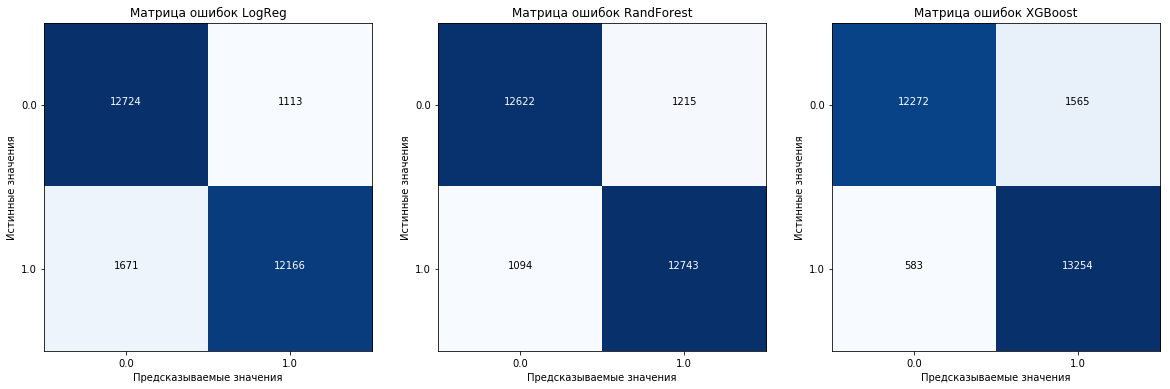

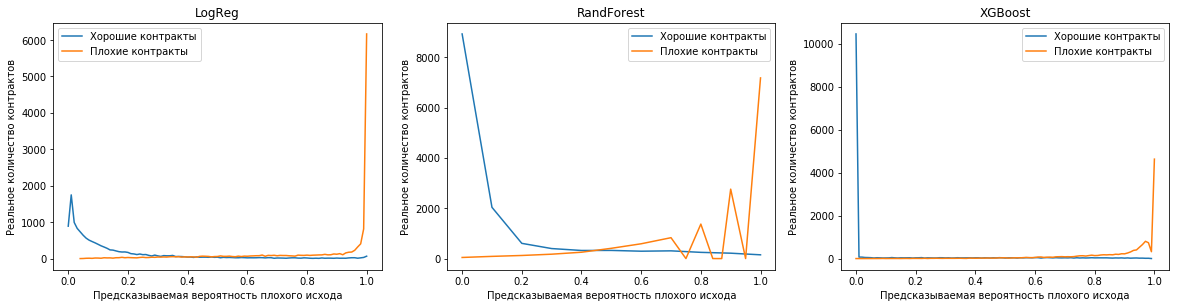

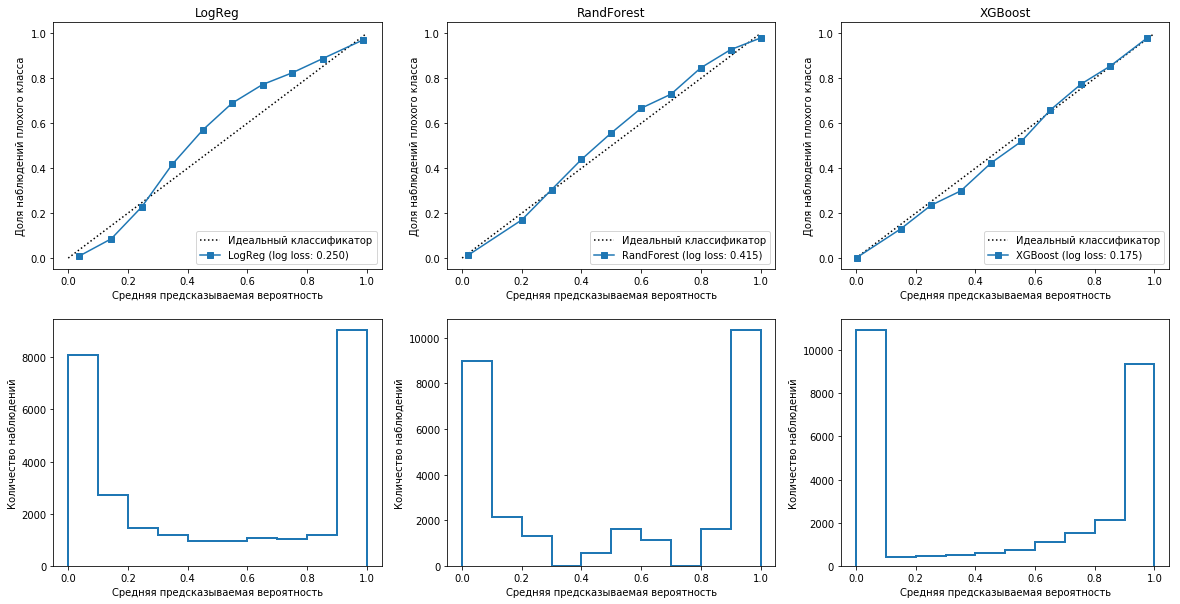

In [25]:
# Основные графики
visualize_clfs_quality(classifiers)

### Подбор параметров

In [26]:
result = pd.read_csv('parameter_tuning_v{}.csv'.format(VERSION))

In [27]:
# Форматирование
result.insert(0, 'algorithm', result['Unnamed: 0'].apply(lambda a: pd.Series(a.split()[0].strip())))
result.insert(1, 'params', result['Unnamed: 0'].apply(lambda a: pd.Series(a.split()[1].strip())))

result.loc[result.algorithm=='LogRer', 'algorithm'] = 'LogReg'

result.drop(['Unnamed: 0'], inplace=True, axis=1)
result = result.round(3)

In [28]:
# 5 случайных строк
result.sample(5, random_state=RANDOM_SEED)

,algorithm,params,train_acc,train_auc,train_ll,test_acc,test_auc,test_ll,valid_acc,valid_auc,valid_ll,time
219,XGBoost,0.3_Silent_8_100_42_1,0.964,0.964,0.103,0.923,0.923,0.176,0.932,0.932,0.165,49.0
66,XGBoost,0.03_Silent_3_1000_42_1,0.961,0.961,0.106,0.923,0.923,0.180,0.929,0.929,0.167,171.0
9,LogReg,0.1_l1_42_saga,0.900,0.900,0.250,0.901,0.901,0.251,0.900,0.900,0.246,6.0
170,XGBoost,0.1_Silent_8_1000_42_0.85,1.000,1.000,0.004,0.922,0.922,0.253,0.925,0.925,0.234,549.0
15,LogReg,1_l2_42_saga,0.900,0.900,0.250,0.900,0.900,0.251,0.901,0.901,0.246,13.0


In [29]:
print('Подбор параметров занял {:.2f}'.format(sum(result.time) / 3600))
print('Подбор параметров для LogReg занял {:.2f}'.format(sum(result.loc[result.algorithm=='LogReg'].time) / 3600))
print('Подбор параметров для RandForest занял {:.2f}'.format(sum(result.loc[result.algorithm=='RandForest'].time) / 3600))
print('Подбор параметров для XGBoost занял {:.2f}'.format(sum(result.loc[result.algorithm=='XGBoost'].time) / 3600))

Подбор параметров занял 9.39
Подбор параметров для LogReg занял 0.12
Подбор параметров для RandForest занял 0.72
Подбор параметров для XGBoost занял 8.55


In [30]:
# Топ 5 лучших и топ 5 быстрых в обучении моделей на базе логистической регрессии
pd.concat(
    (result.loc[result.algorithm=='LogReg'].sort_values(by='valid_ll').head(5),
    result.loc[result.algorithm=='LogReg'].sort_values(by='time').head(5))
)

,algorithm,params,train_acc,train_auc,train_ll,test_acc,test_auc,test_ll,valid_acc,valid_auc,valid_ll,time
23,LogReg,100_l2_42_saga,0.901,0.901,0.249,0.901,0.901,0.250,0.903,0.903,0.245,13.0
21,LogReg,100_l1_42_saga,0.901,0.901,0.249,0.901,0.901,0.250,0.903,0.903,0.245,16.0
20,LogReg,100_l1_42_liblinear,0.901,0.901,0.249,0.901,0.901,0.250,0.903,0.903,0.245,27.0
19,LogReg,10_l2_42_saga,0.901,0.901,0.249,0.901,0.901,0.250,0.903,0.903,0.245,13.0
18,LogReg,10_l2_42_liblinear,0.901,0.901,0.249,0.901,0.901,0.250,0.903,0.903,0.245,3.0
0,LogReg,0.001_l1_42_liblinear,0.801,0.801,0.497,0.800,0.800,0.497,0.801,0.801,0.495,1.0
2,LogReg,0.001_l2_42_liblinear,0.800,0.800,0.477,0.800,0.800,0.477,0.802,0.802,0.472,1.0
6,LogReg,0.01_l2_42_liblinear,0.865,0.865,0.343,0.865,0.865,0.343,0.866,0.866,0.339,1.0
1,LogReg,0.001_l1_42_saga,0.835,0.835,0.426,0.834,0.834,0.426,0.836,0.836,0.426,2.0
3,LogReg,0.001_l2_42_saga,0.811,0.811,0.467,0.811,0.811,0.467,0.816,0.816,0.462,2.0


Качество 5 лучших моделей практически не отличается, поэтому выбираем из них самую быструю в обучении - **№18**.
Самые быстрые модели сильно отстают в качестве от 5 лучших, в связи с чем выбор окончательный.

In [31]:
# Топ 5 лучших и топ 5 быстрых в обучении моделей на базе случайного леса
pd.concat(
    (result.loc[result.algorithm=='RandForest'].sort_values(by='valid_ll').head(5),
    result.loc[result.algorithm=='RandForest'].sort_values(by='time').head(5))
)

,algorithm,params,train_acc,train_auc,train_ll,test_acc,test_auc,test_ll,valid_acc,valid_auc,valid_ll,time
51,RandForest,8_1000_42,0.932,0.932,0.204,0.920,0.920,0.224,0.926,0.926,0.218,274.0
50,RandForest,8_800_42,0.932,0.932,0.204,0.920,0.920,0.225,0.927,0.927,0.218,220.0
48,RandForest,8_400_42,0.932,0.932,0.204,0.920,0.920,0.225,0.927,0.927,0.219,110.0
49,RandForest,8_600_42,0.932,0.932,0.204,0.920,0.920,0.225,0.927,0.927,0.220,165.0
47,RandForest,8_200_42,0.932,0.932,0.206,0.920,0.920,0.226,0.927,0.927,0.221,55.0
24,RandForest,3_10_42,0.907,0.906,0.377,0.906,0.906,0.378,0.904,0.904,0.377,2.0
38,RandForest,6_10_42,0.920,0.920,0.241,0.915,0.915,0.249,0.921,0.921,0.241,2.0
31,RandForest,4_10_42,0.912,0.912,0.321,0.911,0.911,0.325,0.914,0.914,0.322,2.0
45,RandForest,8_10_42,0.930,0.930,0.200,0.917,0.917,0.222,0.924,0.924,0.227,3.0
25,RandForest,3_100_42,0.913,0.913,0.384,0.912,0.912,0.386,0.915,0.915,0.384,16.0


Качество 5 лучших моделей практически не отличается, поэтому выбираем из них самую быструю в обучении - № 47.
Некоторые из самых быстрых моделей не сильно отстают в качестве от 5 лучших, в связи с чем интересным вариантом представляется модель №45.

Но выбирать модели с большой глубиной деревьей тоже не хорошо. Такие модели демонстрируют более варьирующееся качество на тренировочных, тестовых и валидационных выборках, чем модели с неглубокими деревьями.

Поэтому финальными вариантами представляются модель **№45**.

In [32]:
# Топ 5 лучших и топ 5 быстрых в обучении моделей на базе градиентного бустинга
pd.concat(
    (result.loc[result.algorithm=='XGBoost'].sort_values(by='valid_ll').head(5), 
     result.loc[result.algorithm=='XGBoost'].sort_values(by='time').head(5))
)

,algorithm,params,train_acc,train_auc,train_ll,test_acc,test_auc,test_ll,valid_acc,valid_auc,valid_ll,time
204,XGBoost,0.3_Silent_6_100_42_1,0.943,0.943,0.137,0.923,0.923,0.175,0.931,0.932,0.163,35.0
84,XGBoost,0.03_Silent_6_100_42_1,0.943,0.943,0.137,0.923,0.923,0.175,0.931,0.932,0.163,37.0
207,XGBoost,0.3_Silent_6_200_42_1,0.964,0.964,0.102,0.924,0.924,0.176,0.930,0.930,0.163,71.0
87,XGBoost,0.03_Silent_6_200_42_1,0.964,0.964,0.102,0.924,0.924,0.176,0.930,0.930,0.163,71.0
147,XGBoost,0.1_Silent_6_200_42_1,0.964,0.964,0.102,0.924,0.924,0.176,0.930,0.930,0.163,71.0
54,XGBoost,0.03_Silent_3_100_42_1,0.924,0.924,0.171,0.920,0.920,0.180,0.929,0.929,0.170,18.0
174,XGBoost,0.3_Silent_3_100_42_1,0.924,0.924,0.171,0.920,0.920,0.180,0.929,0.929,0.170,18.0
114,XGBoost,0.1_Silent_3_100_42_1,0.924,0.924,0.171,0.920,0.920,0.180,0.929,0.929,0.170,18.0
53,XGBoost,0.03_Silent_3_100_42_0.85,0.925,0.925,0.170,0.920,0.920,0.179,0.930,0.930,0.169,19.0
113,XGBoost,0.1_Silent_3_100_42_0.85,0.925,0.925,0.170,0.920,0.920,0.179,0.930,0.930,0.169,19.0


Качество 5 лучших моделей практически не отличается, поэтому выбираем из них самую быструю в обучении - №204 и №84. Но сравнивая с самыми быстрыми в обучении моделями, можно найти вариант, который не сильно уступает в качестве, а обучается значительно быстрее - **№113**.

### Отбор признаков

In [33]:
rfe_classifiers = [
    Classifier(
        LogisticRegression(C=10, solver='liblinear', random_state=RANDOM_SEED),
        'LogisticRegression', 'RFE_T_LogReg', 'LR'),
     Classifier(
        RandomForestClassifier(random_state=RANDOM_SEED, max_depth=8, n_estimators=10), 
        'RandomForestClassifier', 'RFE_T_RandForest', 'RF'),
    Classifier(
        XGBClassifier(random_state=RANDOM_SEED, eta=0.1, max_depth=3, n_estimators=100, subsample=0.85), 
        'XGBoostClassifier', 'RFE_T_XGBoost', 'XGB')
]

RFE для RFE_T_LogReg
26 сек: sup_cntr_num, sup_running_cntr_num, sup_cntr_avg_price, org_cntr_num, org_cntr_avg_price, one_day_price, sup_good_cntr_share, sup_fed_cntr_share, sup_sub_cntr_share, sup_mun_cntr_share, sup_sim_price_share, org_good_cntr_share, org_sim_price_share, okpd_good_cntr_share, org_type, okpd2, quarter

RFE для RFE_T_RandForest
40 сек: sup_good_cntr_share, sup_sim_price_share, org_good_cntr_share, okpd_good_cntr_share

RFE для RFE_T_XGBoost
242 сек: sup_cntr_num, sup_running_cntr_num, sup_cntr_avg_price, org_cntr_num, org_cntr_avg_price, org_running_cntr_num, cntr_length, one_day_price, sup_good_cntr_share, sup_fed_cntr_share, sup_sub_cntr_share, sup_sim_price_share, org_good_cntr_share, org_sim_price_share, okpd_good_cntr_share, org_type, okpd2

Wall time: 5min 9s


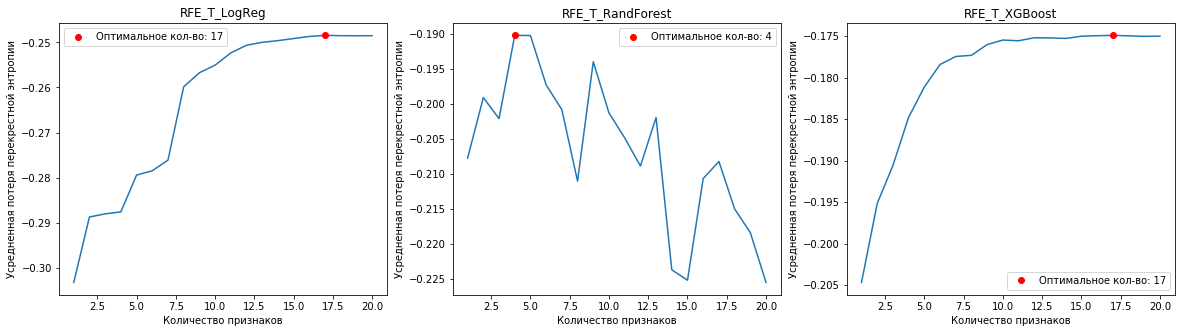

In [34]:
%%time
# Отбор признаков
fig = plt.figure(figsize=(20, 5))
rfecvs = []
for idx, clf in enumerate(rfe_classifiers):
    start_time = time.time()
    
    print('RFE для %s' % clf.short_name)
    rfecv = RFECV(
        clf.clf, step=1, cv=StratifiedKFold(n_splits=10, random_state=RANDOM_SEED), 
        scoring='neg_log_loss')
    rfecv.fit(X, y)
    rfecvs.append(rfecv)
    
    ax = fig.add_subplot(1, 3, idx + 1)
    ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    ax.plot(rfecv.n_features_, max(rfecv.grid_scores_), 'ro', label='Оптимальное кол-во: {}'.format(rfecv.n_features_))
    ax.set_title(clf.short_name)
    ax.set_xlabel("Количество признаков")
    ax.set_ylabel("Усредненная потеря перекрестной энтропии")
    ax.legend()
    
    best_set_of_features = [
        column for (score, column) in zip(list(rfecv.support_), list(data.columns[1:-1])) if score
    ]

    print("{} сек: {}\n".format(
        int(time.time() - start_time), 
        ', '.join(best_set_of_features)
    ))

In [40]:
# Переменные в порядке убывания важности для алгоритма
rfe_t_log_reg_fi = sorted(
    list(zip(data.columns[1:-1], classifiers[0].clf.coef_[0])),
    key=lambda a: np.abs(a[1]), 
    reverse=True
)

rfe_t_rand_forest_fi = sorted(
    list(zip(data.columns[1:-1], classifiers[1].clf.feature_importances_)),
    key=lambda a: a[1], 
    reverse=True
)

rfe_t_xgboost_fi = sorted(
    list(zip(data.columns[1:-1], classifiers[2].clf.feature_importances_)),
    key=lambda a: a[1],
    reverse=True
)

# Выбор отобранных переменных для каждого алгортитма
rfe_t_log_reg_fi = [column for column, value in rfe_t_log_reg_fi[:12]]
rfe_t_rand_forest_fi = [column for column, value in rfe_t_rand_forest_fi[:4]]
rfe_t_xgboost_fi = [column for column, value in rfe_t_xgboost_fi[:10]]

In [41]:
%%time
# Обучение моделей на выбранных переменных
for idx, clf in enumerate(rfe_classifiers):
    if idx == 0:
        # Обучение логистической регресси
        X = data[rfe_t_log_reg_fi].values
        learn_one_model(clf, clf.short_name, X, y, silent=True)
    elif idx == 1:
        # Обучение случайного леса
        X = data[rfe_t_rand_forest_fi].values
        learn_one_model(clf, clf.short_name, X, y, silent=True)
    else:
        # Обучение градиентного бустинга
        X = data[rfe_t_xgboost_fi].values
        learn_one_model(clf, clf.short_name, X, y, silent=True)

Обучение RFE_T_LogReg
Обучение RFE_T_RandForest
Обучение RFE_T_XGBoost
Wall time: 16.3 s


In [42]:
custom_classification_report(rfe_classifiers)

,RFE_T_LogReg,RFE_T_RandForest,RFE_T_XGBoost
precision_0,0.883,0.946,0.954
precision_1,0.915,0.890,0.894
recall_0,0.919,0.883,0.887
recall_1,0.879,0.950,0.957
accuracy,0.899,0.916,0.922


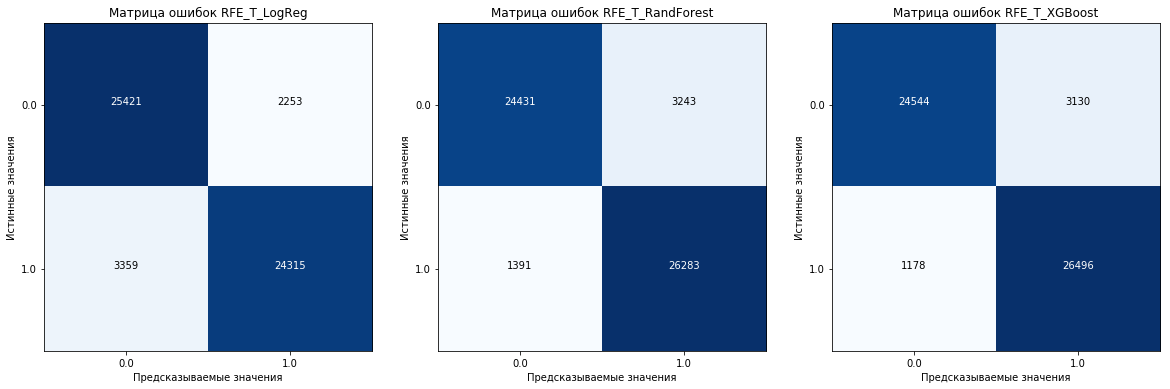

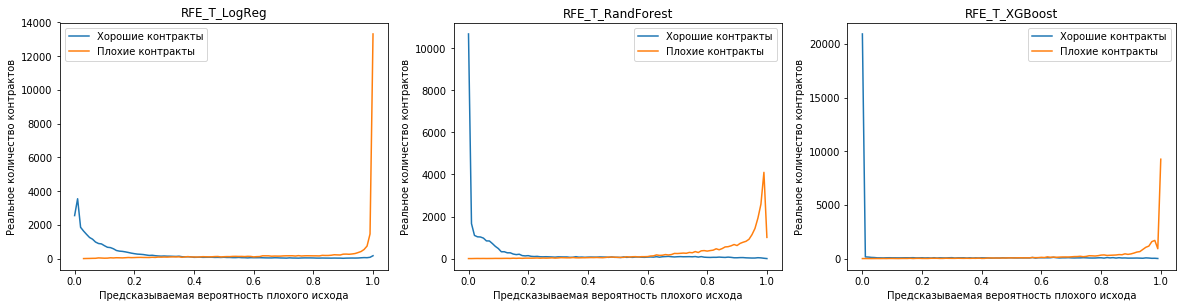

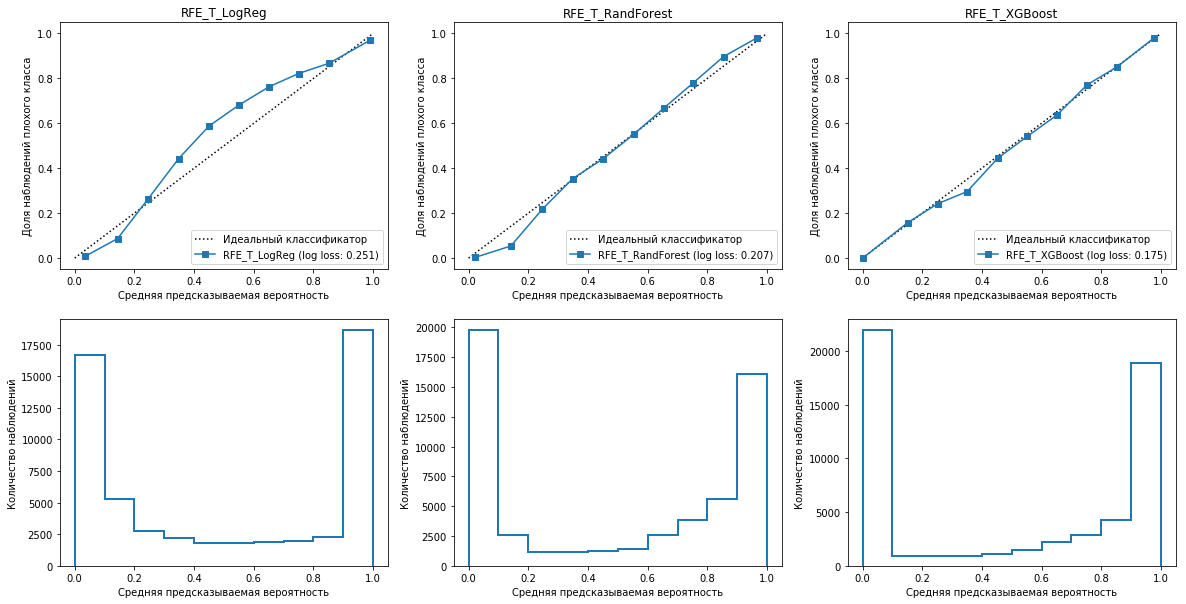

In [43]:
# plot_confusion_matrixes(rfe_classifiers, figsize=(15,5))
visualize_clfs_quality(rfe_classifiers)